In [1]:
# =====================================
# Basic Setup & Utilities
# =====================================
import warnings
import joblib
import numpy as np
import pandas as pd

# =====================================
# Visualization
# =====================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)


In [2]:
import pandas as pd

df = pd.read_excel("Self-Suffciency Rate.xlsx", engine="openpyxl")

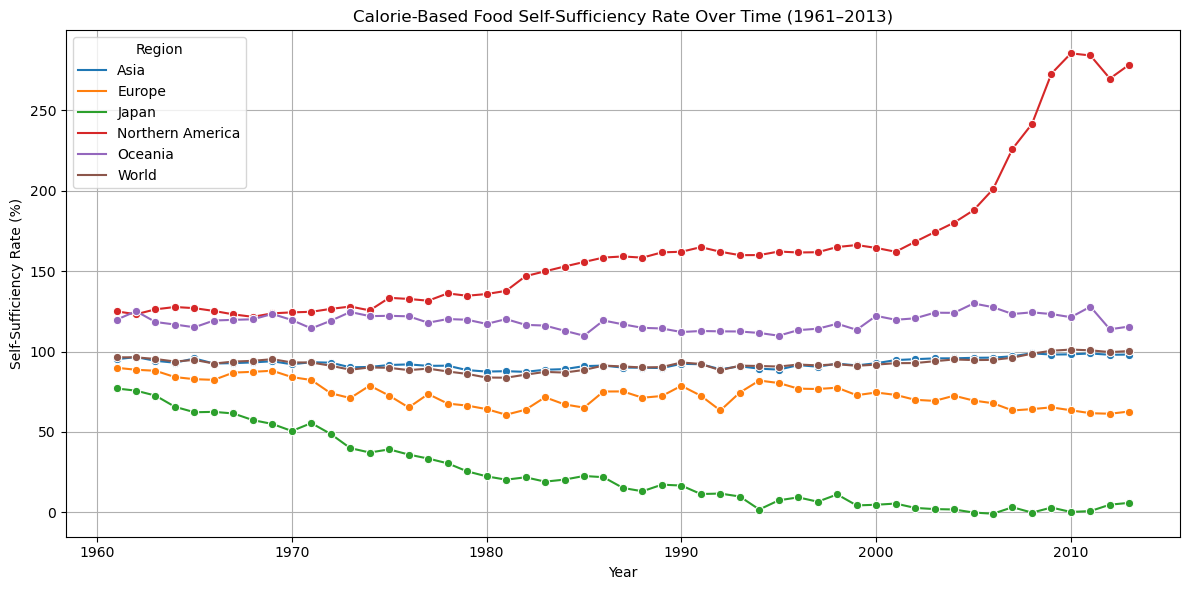

In [6]:
# =======================
# Calorie-based Food Self-Sufficiency Rate
# =======================

# ================================
# Denominator: Food supply per capita (kcal/day)
# ================================
supply_df = df[df["Element"] == "Food supply (kcal/capita/day)"].copy()
supply_df = supply_df.groupby(["Area", "Year"], as_index=False)["Value"].sum()
supply_df = supply_df.rename(columns={"Value": "kcal_supply"})

# ================================
# Numerator: Total amount of calories effectively available for food
# ================================

# Elements used (to exclude non-food uses)
elements_needed = [
    "Production",          # Total production
    "Feed",                # Feed use
    "Seed",                # Seed use
    "Losses",              # Losses
    "Other Uses (non-food)",  # Non-food uses
    "Processed",           # Processing
    "Export Quantity",     # Exports
    "Stock Variation"      # Stock changes (positive = increase)
]

# Unify item names (e.g., "Rice" → "Rice (Milled Equivalent)")
df["Item"] = df["Item"].replace({"Rice and products": "Rice (Milled Equivalent)"})

# Calorie conversion factors per item (kcal/kg)
kcal_factors = {
    "Wheat and products": 3320,
    "Rice (Milled Equivalent)": 3650,
    "Barley and products": 3520,
    "Maize and products": 3700,
    "Potatoes and products": 770,
    "Soybeans": 4460,
    "Vegetables, other": 720,
    "Bovine Meat": 1430,
    "Pigmeat": 1090,
    "Eggs": 1430,
    "Milk - Excluding Butter": 610,
    "Poultry Meat": 1200,
    "Pulses, Other and products": 3520,
    "Sugar (Raw Equivalent)": 3870,
    "Soyabean Oil": 8840,
    "Pelagic Fish": 1420
}

# Extract data for relevant items and elements
filtered_df = df[
    df["Element"].isin(elements_needed) &
    df["Item"].isin(kcal_factors.keys())
].copy()

# Pivot data by element
pivot_df = filtered_df.pivot_table(
    index=["Area", "Year", "Item"],
    columns="Element",
    values="Value",
    aggfunc="sum"
).fillna(0).reset_index()

# Calculate food-available quantity per item (in 1,000 tons)
pivot_df["adjusted_food_1000t"] = (
    pivot_df.get("Production", 0)
    - pivot_df.get("Feed", 0)
    - pivot_df.get("Seed", 0)
    - pivot_df.get("Losses", 0)
    - pivot_df.get("Other Uses (non-food)", 0)
    - pivot_df.get("Processed", 0)
    - pivot_df.get("Export Quantity", 0)
    + pivot_df.get("Stock Variation", 0)
)

# Convert units: kg → kcal
pivot_df["kg"] = pivot_df["adjusted_food_1000t"] * 1_000_000
pivot_df["kcal"] = pivot_df["kg"] * pivot_df["Item"].map(kcal_factors)

# Sum total kcal by region and year
kcal_total_df = pivot_df.groupby(["Area", "Year"], as_index=False)["kcal"].sum()

# ================================
# Import and format population data
# ================================
pop_df = df[df["Element"] == "Total Population - Both sexes"].copy()
pop_df = pop_df[["Area", "Year", "Value"]].rename(columns={"Value": "Population"})
pop_df["Population"] = pd.to_numeric(pop_df["Population"], errors="coerce") * 1000  # Unit: people

# ================================
# Calculate per capita available calories per day
# ================================
merged_df = pd.merge(kcal_total_df, pop_df, on=["Area", "Year"], how="left")
merged_df["kcal_per_capita_day"] = merged_df["kcal"] / merged_df["Population"] / 365

# ================================
# Merge with food supply data → compute self-sufficiency rate
# ================================
final_df = pd.merge(
    merged_df[["Area", "Year", "kcal_per_capita_day"]],
    supply_df[["Area", "Year", "kcal_supply"]],
    on=["Area", "Year"],
    how="inner"
)
final_df["self_sufficiency_rate"] = (final_df["kcal_per_capita_day"] / final_df["kcal_supply"]) * 100

# ================================
# Visualization: Time-series plot by region (+ save as image)
# ================================
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x="Year", y="self_sufficiency_rate", hue="Area", marker="o")
plt.title("Calorie-Based Food Self-Sufficiency Rate Over Time (1961–2013)")
plt.ylabel("Self-Sufficiency Rate (%)")
plt.xlabel("Year")
plt.grid(True)
plt.legend(title="Region")
plt.tight_layout()

# Save the graph as a high-resolution PNG image
plt.savefig("Calorie_Based_Food_Self_Sufficiency_Rate_Trend.png", dpi=300, bbox_inches="tight")

plt.show()


# 1. Calorie-Based Food Self-Sufficiency Rate: Summary


- Japan’s calorie-based food self-sufficiency rate is much lower than other regions.
- The rate in Japan has declined over tie.


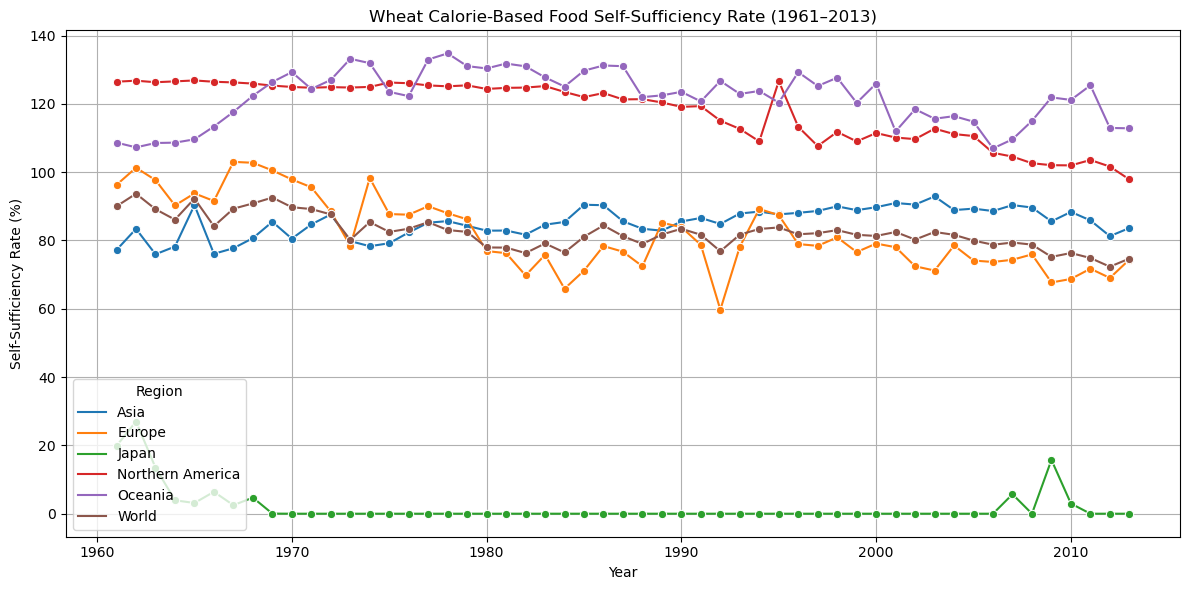

In [7]:
# ============================
# 2. Calorie-Based Wheat Self-Sufficiency Rate
# ============================

# ================================
# Calculate wheat self-sufficiency rate (in kcal/capita/day)
# ================================

# ================================
# Calorie conversion factor (kcal/kg)
# ================================
kcal_factors = {
    "Wheat and products": 3320
}

# ================================
# Denominator: Per capita food supply of wheat (Food supply)
# ================================
supply_df = df[
    (df["Element"].str.strip().str.title() == "Food Supply (Kcal/Capita/Day)") &
    (df["Item"] == "Wheat and products")
].copy()
supply_df = supply_df.groupby(["Area", "Year"], as_index=False)["Value"].sum()
supply_df = supply_df.rename(columns={"Value": "kcal_supply"})

# ================================
# Numerator: Edible calories of wheat (excluding non-food uses)
# ================================
elements_needed = [
    "Production", "Feed", "Seed", "Losses",
    "Other Uses (non-food)", "Processed",
    "Export Quantity", "Stock Variation"
]

# Extract wheat-only data with relevant elements
filtered_df = df[
    (df["Item"] == "Wheat and products") &
    (df["Element"].isin(elements_needed))
].copy()

# Pivot by element
pivot_df = filtered_df.pivot_table(
    index=["Area", "Year"],
    columns="Element",
    values="Value",
    aggfunc="sum"
).fillna(0).reset_index()

# Calculate net edible quantity (in 1,000 tons)
pivot_df["adjusted_food_1000t"] = (
    pivot_df.get("Production", 0)
    - pivot_df.get("Feed", 0)
    - pivot_df.get("Seed", 0)
    - pivot_df.get("Losses", 0)
    - pivot_df.get("Other Uses (non-food)", 0)
    - pivot_df.get("Processed", 0)
    - pivot_df.get("Export Quantity", 0)
    + pivot_df.get("Stock Variation", 0)
)

# Clip negative values to 0 (to avoid unrealistic values)
pivot_df["adjusted_food_1000t"] = pivot_df["adjusted_food_1000t"].clip(lower=0)

# Convert to kcal
pivot_df["kcal"] = pivot_df["adjusted_food_1000t"] * 1_000_000 * kcal_factors["Wheat and products"]
kcal_total_df = pivot_df[["Area", "Year", "kcal"]]

# ================================
# Format population data (thousands → individuals)
# ================================
pop_df = df[df["Element"] == "Total Population - Both sexes"].copy()
pop_df = pop_df[["Area", "Year", "Value"]].rename(columns={"Value": "Population"})
pop_df["Population"] = pd.to_numeric(pop_df["Population"], errors="coerce") * 1000

# ================================
# Calculate per capita wheat-derived kcal/day
# ================================
merged_df = pd.merge(kcal_total_df, pop_df, on=["Area", "Year"], how="left")
merged_df = merged_df[merged_df["Population"] > 0]
merged_df["kcal_per_capita_day"] = merged_df["kcal"] / merged_df["Population"] / 365

# ================================
# Calculate wheat calorie-based self-sufficiency rate
# ================================
final_df = pd.merge(
    merged_df[["Area", "Year", "kcal_per_capita_day"]],
    supply_df[["Area", "Year", "kcal_supply"]],
    on=["Area", "Year"],
    how="inner"
)
final_df["self_sufficiency_rate"] = (
    final_df["kcal_per_capita_day"] / final_df["kcal_supply"]
) * 100

# ================================
# Visualization + Save as PNG
# ================================
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=final_df,
    x="Year",
    y="self_sufficiency_rate",
    hue="Area",
    marker="o"
)
plt.title("Wheat Calorie-Based Food Self-Sufficiency Rate (1961–2013)")
plt.ylabel("Self-Sufficiency Rate (%)")
plt.xlabel("Year")
plt.grid(True)
plt.legend(title="Region")
plt.tight_layout()

# Save the chart as a high-resolution PNG
plt.savefig("Wheat_Calorie_Based_Self_Sufficiency_Trend.png", dpi=300, bbox_inches="tight")

plt.show()


# 2. Wheat Calorie-Based Food Self-Sufficiency Rate: Summary

- Japan's wheat calorie-based self-sufficiency rate is significantly lower than that of other regions.
- Major producers like North America and Oceania maintain high self-sufficiency rates (over 100%).